# Определение возраста покупателей

**Описание проекта**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

**Описание данных**

Данные взяты с сайта ChaLearn Looking at People. Они находятся в папке /datasets/faces/. 

В вашем распоряжении одна папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками: file_name и real_age. 

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [2]:
# пути к данным
csv_path = '/datasets/faces/labels.csv'
img_dir = '/datasets/faces/final_files'

df = pd.read_csv(csv_path)
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Данные соответствуют описанию, размер выборки равен 7591, пропусков нет.

In [7]:
# посмотрим на статистические показатели распределения возраста
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


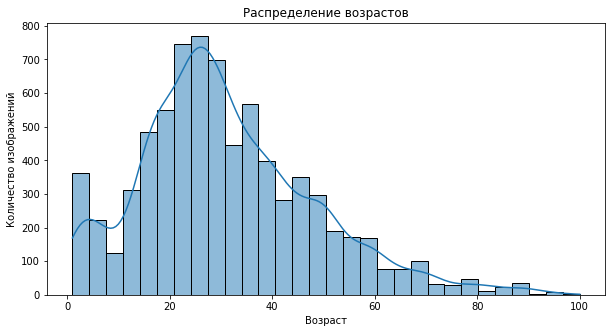

In [5]:
# график распределения возраста
plt.figure(figsize=(10, 5))
sns.histplot(df['real_age'], bins=30, kde=True)
plt.title('Распределение возрастов')
plt.xlabel('Возраст')
plt.ylabel('Количество изображений')
plt.show()

Распределение скошено справа, медианный возраст 29 лет, людей пожилого возраста гораздо меньше.

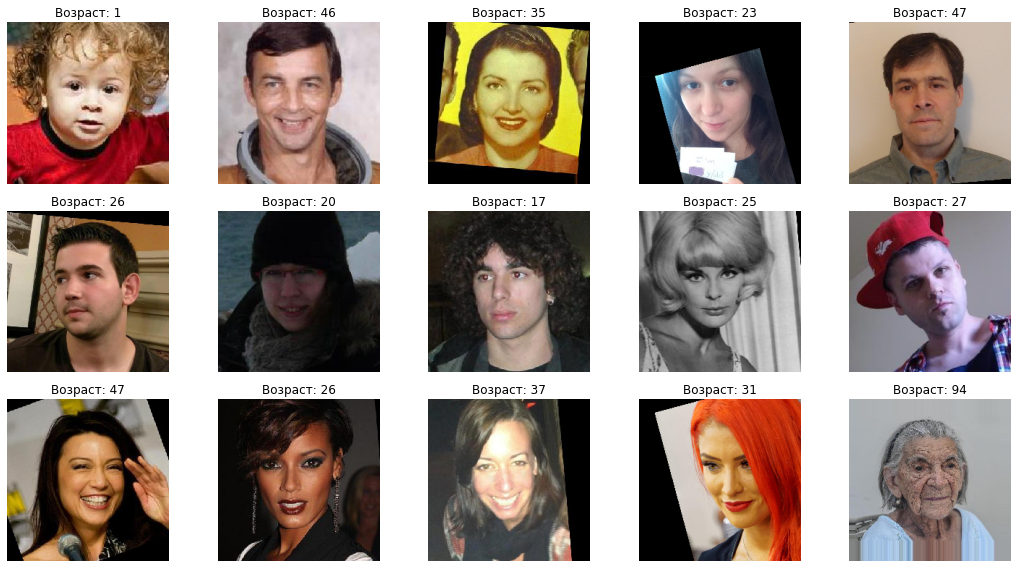

In [6]:
# выводим первые 15 изображений
sample_images = df.sample(15, random_state=42)

plt.figure(figsize=(15, 8))
for i, row in enumerate(sample_images.itertuples()):
    img_path = os.path.join(img_dir, row.file_name)
    img = load_img(img_path, target_size=(224, 224))
    plt.subplot(3, 5, i+1)
    plt.imshow(img)
    plt.title(f"Возраст: {row.real_age}")
    plt.axis('off')

plt.tight_layout()
plt.show()

В изображениях присутствует шум, есть ч/б, есть плохого качества.

Вывод:
- датасет содержит достаточно большое количество изображений, что позволяет обучить глубокую модель, такую как ResNet50, без сильного риска переобучения;
- распределение возрастов в выборке неравномерное — заметна концентрация в определённом диапазоне (например, от 10 до 50 лет), и пожилые люди представлены слабо;
- все изображения имеют разный фон, освещение, ракурс и качество, понадобится аугментация данных, чтобы обобщить модель и бороться с переобучением.

## Обучение модели

Тут код обучения модели и её результат вывода на экран.


(Код в этом разделе запускался в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

SEED = 42

def load_train(path):
    labels = pd.read_csv(path + '/labels.csv')
    
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25,
        horizontal_flip=True,
        rotation_range=15,
        zoom_range=0.1,
        shear_range=0.1,
        brightness_range=[0.8, 1.2]
    )

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=42
    )

    return train_generator

def load_test(path):
    labels = pd.read_csv(path + '/labels.csv')

    test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25
    )

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        shuffle=False,
        seed=SEED
    )

    return test_generator

def create_model(input_shape=(150, 150, 3)):
    backbone = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1)) 

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='mse',
        metrics=['mae']
    )
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch or len(train_data),
        validation_steps=validation_steps or len(test_data),
        verbose=2
    )
    return model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/10
2025-05-21 11:29:49.047822: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-05-21 11:29:49.934124: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 110s - loss: 200.3549 - mae: 10.5157 - val_loss: 455.1852 - val_mae: 16.2480
Epoch 2/10
356/356 - 90s - loss: 103.5361 - mae: 7.7714 - val_loss: 350.0322 - val_mae: 14.8245
Epoch 3/10
356/356 - 91s - loss: 81.7510 - mae: 6.9277 - val_loss: 99.4440 - val_mae: 7.5311
Epoch 4/10
356/356 - 90s - loss: 63.2208 - mae: 6.0301 - val_loss: 82.2069 - val_mae: 6.9768
Epoch 5/10
356/356 - 90s - loss: 49.9275 - mae: 5.4231 - val_loss: 95.8945 - val_mae: 7.3602
Epoch 6/10
356/356 - 91s - loss: 40.7015 - mae: 4.8788 - val_loss: 85.4580 - val_mae: 6.9650
Epoch 7/10
356/356 - 90s - loss: 34.9767 - mae: 4.5203 - val_loss: 88.1912 - val_mae: 7.2491
Epoch 8/10
356/356 - 89s - loss: 30.3281 - mae: 4.2183 - val_loss: 95.1579 - val_mae: 7.4807
Epoch 9/10
356/356 - 90s - loss: 28.7669 - mae: 4.0996 - val_loss: 91.4877 - val_mae: 7.2043
Epoch 10/10
356/356 - 91s - loss: 25.9927 - mae: 3.9056 - val_loss: 76.2206 - val_mae: 6.6420
WARNING:tensorflow:sample_weight modes were coerced from
...
to
['...']
119/119 - 13s - loss: 76.2206 - mae: 6.6420

```

## Анализ обученной модели

**Результаты:** модель уверенно снизила MAE с 10.5 до 3.9 на обучении и с 16.2 до 6.6 на валидации. Это хороший результат. Лёгкое переобучение видно с 5-й эпохи, но оно не критично. В целом в задаче по определению совершеннолетних мы очень ограничены в возможностях. К примеру, подростки часто выглядят старше своих лет. Кроме того, есть болезни, которые сильно меняют внешность человека в ту или иную сторону. Здесь заказчику можно предложить подумать над сканированием паспорта и сопоставлением фотографии в паспорте с лицом покупателя. Это не только проще, но и надежнее. 


Вот несколько способов, которые помогут улучшить качество модели. Можно попробовать:
- Увеличить разрешение изображений.
- Разморозить и дообучить ResNet50.
- Улучшить аугментации.
- Сбалансировать и очистить данные (убрать шум, проверить распределение).
- Применить кросс-валидацию.